# Programm zur Erkennung von Hunderassen

## Schritt 1: Daten laden und Aufteilen in Trainings- und Testdaten

In [28]:
# Importieren der notwendigen Bibliotheken
import os
import numpy as np
import xml.etree.ElementTree as ET
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [29]:
# Definieren der Pfade zum Datensatz und zu den Annotationen
dataset_path = 'dogs'
annotation_path = 'annotations'


In [30]:
# Funktion zum Parsen der Annotationsdateien
def parse_annotation(xml_file):
    # Parsen der XML-Datei
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndboxes = []  # Liste zum Speichern der Bounding Boxes
    # Durchlaufen aller Objekte in der XML-Datei
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')  # Finden des Bounding Box-Elements
        # Extrahieren der Koordinaten der Bounding Box
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        # Hinzufügen der Bounding Box zur Liste
        bndboxes.append((xmin, ymin, xmax, ymax))
    return bndboxes  # Rückgabe der Liste der Bounding Boxes

### Laden der Daten
Im folgenden werden die rohen Bilder mit den Annotations kombiniert und die einzeln zugeschnittenen Hunde werden als Bild gespeichert. Damit kann die Erkennung von Störungen aus dem Hintergrund verringert werden.

In [31]:
# Laden der Bilder und Extrahieren der Hundebereiche
images = []  # Liste zum Speichern der zugeschnittenen Bilder
labels = []  # Liste zum Speichern der zugehörigen Labels (Hunderassen)
breeds = os.listdir(dataset_path)  # Auflisten aller Hunderassen im Datensatz

# Durchlaufen jeder Hunderasse
for breed in breeds:
    breed_img_path = os.path.join(dataset_path, breed)  # Pfad zu den Bildern der aktuellen Rasse
    breed_anno_path = os.path.join(annotation_path, breed)  # Pfad zu den Annotationen der aktuellen Rasse
    if os.path.isdir(breed_img_path):  # Überprüfen, ob der Pfad ein Verzeichnis ist
        # Durchlaufen aller Bilder in dem Verzeichnis der aktuellen Rasse
        for img_name in os.listdir(breed_img_path):
            img_path = os.path.join(breed_img_path, img_name)  # Vollständiger Pfad zum Bild
            annotation_name = os.path.splitext(img_name)[0]  # Entfernen der Dateierweiterung
            annotation_file = os.path.join(breed_anno_path, annotation_name)  # Pfad zur zugehörigen Annotationsdatei
            if not os.path.exists(annotation_file):
                continue  # Überspringen, wenn keine Annotationsdatei vorhanden ist
            image = io.imread(img_path)  # Laden des Bildes
            if image is None:
                continue  # Überspringen, wenn das Bild nicht geladen werden konnte
            bndboxes = parse_annotation(annotation_file)  # Parsen der Annotationsdatei, um die Bounding Boxes zu erhalten
            # Durchlaufen jeder Bounding Box im Bild
            for bndbox in bndboxes:
                xmin, ymin, xmax, ymax = bndbox  # Extrahieren der Koordinaten
                # Sicherstellen, dass die Koordinaten innerhalb der Bildgrenzen liegen
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(image.shape[1], xmax)
                ymax = min(image.shape[0], ymax)
                if xmin >= xmax or ymin >= ymax:
                    continue  # Überspringen ungültiger Bounding Boxes
                # Zuschneiden des Bildes auf die Bounding Box
                cropped_image = image[ymin:ymax, xmin:xmax]
                # Ändern der Größe des zugeschnittenen Bildes auf 256x256 Pixel
                cropped_image = transform.resize(cropped_image, (256, 256))
                images.append(cropped_image)  # Hinzufügen des Bildes zur Liste
                labels.append(breed)  # Hinzufügen des Labels zur Liste

### Auswahl der Bilder
Es werden jetzt die Bilder ausgewählt die zum Trainieren verwendet werden, und die, die fürs Testen dann verwendet werden.

In [32]:
# Umwandeln der Labels (Hunderassen) in numerische Werte
le = LabelEncoder()  # Initialisieren des LabelEncoders
y = le.fit_transform(labels)  # Anpassen und Transformieren der Labels

# Überprüfen, ob Bilder geladen wurden
if len(images) == 0:
    print("Fehler: Keine Bilder geladen. Bitte überprüfen Sie den Pfad und die Annotationsdateien.")
else:
    # Aufteilen in Trainings- und Testdaten (75% Training, 25% Test)
    X_train_img, X_test_img, y_train, y_test = train_test_split(
        images, y, test_size=0.25, stratify=y, random_state=42)

In [33]:
# Überprüfen der Anzahl der geladenen Bilder und der Aufteilung
print(f'Anzahl der gesamten Bilder: {len(images)}')
print(f'Anzahl der Trainingsbilder: {len(X_train_img)}')
print(f'Anzahl der Testbilder: {len(X_test_img)}')

Anzahl der gesamten Bilder: 1029
Anzahl der Trainingsbilder: 771
Anzahl der Testbilder: 258


Die Daten wurden erfolgreich geladen und in Trainings- und Testdaten aufgeteilt. Wir haben die relevanten Bildbereiche unter Verwendung der Bounding Boxes extrahiert, um uns auf die Hunde zu konzentrieren und Hintergrundrauschen zu reduzieren.

## Schritt 2: Merkmalsextraktion unter Verwendung der Bounding Box Annotationen

In [34]:
# Importieren weiterer Bibliotheken für die Merkmalsextraktion
from skimage import feature, filters, measure


### Implementierung der Merkmale

Die implementierten Merkmale werden verwendet um
- Fellfarbe
- Textur (z.B. Fellbeschaffenheit)
- Kantenerkennung (z.B. Ohren oder Markante Kanten)
- Statur des Hundes (Mächtigkeit im Gesamtbild)

zu unterscheiden.

Diese Merkmale müssen für das klassische Machine Learning selbst festgelegt werden, ebenso wie die Implementierung dieser.

In [35]:
# Funktionen zur Merkmalsextraktion definieren

# Histogramm der Farbverteilung
# (Fellfarbe des Hundes)
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Konvertieren des Bildes in den HSV-Farbraum
    hsv_image = color.rgb2hsv(image)
    # Berechnen des Histogramms für die H-, S- und V-Kanäle
    hist, _ = np.histogramdd(
        hsv_image.reshape(-1, 3),
        bins=bins,
        range=[(0, 1), (0, 1), (0, 1)]
    )
    hist = hist.flatten()  # Flachmachen des Histogramms zu einem eindimensionalen Array
    hist = hist / np.sum(hist)  # Normalisieren des Histogramms
    return hist  # Rückgabe des normierten Histogramms

# Local Binary Patterns (LBP) für Texturmerkmale
def extract_lbp_features(image, P=8, R=1):
    # Konvertieren des Bildes in Graustufen
    gray_image = color.rgb2gray(image)
    # Berechnen der Local Binary Patterns (LBP) für Texturmerkmale
    lbp = feature.local_binary_pattern(
        gray_image, P=P, R=R, method='uniform'
    )
    n_bins = int(lbp.max() + 1)  # Bestimmen der Anzahl der Histogrammbins
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))  # Berechnen des Histogramms
    hist = hist.astype('float')
    hist /= hist.sum()  # Normalisieren des Histogramms
    return hist  # Rückgabe der LBP-Merkmale

# Formmerkmale
def extract_shape_features(image):
    # Konvertieren des Bildes in Graustufen
    gray_image = color.rgb2gray(image)
    # Anwenden der Otsu-Schwellenwertmethode zur Binärisierung
    thresh = filters.threshold_otsu(gray_image)
    binary_image = gray_image > thresh  # Erzeugen des binären Bildes
    try:
        # Berechnen der Hu-Momente für Formmerkmale
        moments = measure.moments_hu(binary_image)
        return moments  # Rückgabe der Hu-Momente
    except Exception as e:
        print(f"Fehler bei der Berechnung der Hu-Momente: {e}")
        return np.zeros(7)  # Rückgabe eines Nullvektors bei Fehler

# Größe des Hundes
def extract_size_features(image):
    # Konvertieren des Bildes in Graustufen
    gray_image = color.rgb2gray(image)
    # Binärisierung des Bildes mit Otsu-Schwellenwert
    thresh = filters.threshold_otsu(gray_image)
    binary = gray_image > thresh
    label_image = measure.label(binary)  # Labeln der verbundenen Komponenten
    regions = measure.regionprops(label_image)  # Extrahieren der Eigenschaften der Regionen
    if regions:
        # Auswählen der größten Region basierend auf der Fläche
        region = max(regions, key=lambda r: r.area)
        minr, minc, maxr, maxc = region.bbox  # Extrahieren des Bounding Boxes der Region
        height = maxr - minr  # Berechnen der Höhe
        width = maxc - minc  # Berechnen der Breite
        aspect_ratio = height / width if width != 0 else 0  # Berechnen des Seitenverhältnisses
        return np.array([height, width, aspect_ratio])  # Rückgabe der Größenmerkmale
    else:
        return np.zeros(3)  # Rückgabe eines Nullvektors, wenn keine Regionen gefunden wurden


### Extraktion der Merkmale

Die Merkmale werden jetzt auf die übergebenen Bilder für die Trainingsdaten und die Testdaten angewendet

In [36]:
# Extraktion der Merkmale aus den Trainings- und Testdaten

def extract_features(images):
    feature_list = []  # Liste zum Speichern der Merkmalsvektoren
    for image in images:
        # Sicherstellen, dass das Bild 3 Kanäle hat
        if image.shape[2] == 4:
            image = color.rgba2rgb(image)
        
        # Extrahieren des Farbhistogramms
        color_hist = extract_color_histogram(image)
        # Extrahieren der LBP-Merkmale
        lbp_features = extract_lbp_features(image)
        # Extrahieren der Formmerkmale
        shape_features = extract_shape_features(image)
        # Extrahieren der Größenmerkmale
        size_features = extract_size_features(image)

        # Kombinieren aller Merkmale zu einem einzigen Vektor
        feature_vector = np.hstack([
            color_hist, lbp_features,
            shape_features, size_features
            # edge_features, hog_features,
            # gabor_features, haralick_features, entropy_features, fractal_features, fourier_features, zernike_features
        ])
        feature_list.append(feature_vector)  # Hinzufügen des Merkmalsvektors zur Liste
    return np.array(feature_list)  # Rückgabe des Arrays von Merkmalsvektoren

# Extrahieren der Merkmale für Trainings- und Testdaten
X_train = extract_features(X_train_img)
X_test = extract_features(X_test_img)

/Users/phde310272108/Desktop/DHBW/ML/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [37]:
# Überprüfen der Dimensionen der Merkmalsvektoren
print(f'Dimension des Trainings-Merkmalsvektors: {X_train.shape}')
print(f'Dimension des Test-Merkmalsvektors: {X_test.shape}')

Dimension des Trainings-Merkmalsvektors: (771, 532)
Dimension des Test-Merkmalsvektors: (258, 532)


Die Merkmalsextraktion wurde erfolgreich durchgeführt. Die Merkmalsvektoren haben die erwarteten Dimensionen, was darauf hindeutet, dass alle Merkmale korrekt extrahiert wurden.

## Schritt 3: Merkmalsreduktion mittels LDA

Es wird die Lineare Diskriminanzanalyse (LDA) verwendet um die Merkmalsreduktion durchzuführen.
LDA berücksichtigt die Klassenlabels und maximiert die Trennbarkeit zwischen den Klassen. Im Vergleich zur Hauptkomponentenanalyse (PCA), die nur die Varianz maximiert, ist LDA für unser Klassifikationsproblem besser geeignet.

Hier ein kurzerÜberblick über die möglichen Umsetzungen:
- PCA:
    - Vorteile:
		- Einfach zu implementieren.
		-	Reduziert die Dimensionalität effektiv, während die Varianz maximiert wird.
	- Nachteile:
		- Ignoriert die Klassenlabels; kann Merkmale behalten, die für die Klassifikation nicht relevant sind.
- LDA:
	- Vorteile:
		- Nutzt die Klasseninformation; optimiert die Trennbarkeit der Klassen.
		- Kann zu besseren Klassifikationsergebnissen führen.
	- Nachteile:
		- Funktioniert am besten, wenn die Klassen kovarianzhomogen und normalverteilt sind.

In [38]:
# Importieren von LDA für die Merkmalsreduktion
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Bestimmen der maximalen Anzahl von Komponenten
n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]
max_components = min(n_features, n_classes - 1)

# Anwenden von LDA zur Reduzierung der Merkmalsdimension auf die maximal mögliche Anzahl von Komponenten
lda = LDA(n_components=max_components)
X_train_lda = lda.fit_transform(X_train, y_train)  # Anpassen an die Trainingsdaten und Transformieren
X_test_lda = lda.transform(X_test)  # Transformieren der Testdaten



LDA wurde angewendet, um die Dimensionalität der Merkmalsvektoren zu reduzieren und die Klassenunterschiede zu maximieren.

## Schritt 4: Implementierung und Optimierung eines Random-Forest-Klassifikators

Der Random-Forest-Algorithmus ist ein Ensemble-Lernverfahren, das mehrere Entscheidungsbäume trainiert und deren Vorhersagen kombiniert, um die Genauigkeit und Robustheit zu verbessern.

### Implementierungsschritte:

1. **Initialisierung des Random-Forest-Klassifikators**:
    - Wir initialisieren den Random-Forest-Klassifikator mit einem festen Zufallszustand, um reproduzierbare Ergebnisse zu gewährleisten.

2. **Hyperparameter-Optimierung**:
    - Wir definieren ein Parametergrid für die Anzahl der Bäume (`n_estimators`) und die maximale Tiefe der Bäume (`max_depth`).
    - Wir verwenden `GridSearchCV`, um die besten Hyperparameter zu finden. Dabei wird eine Kreuzvalidierung mit stratifizierten Folds (`StratifiedKFold`) verwendet, um sicherzustellen, dass die Klassenverteilung in jedem Fold gleich ist.

3. **Training des Modells**:
    - Wir passen das Modell an die Trainingsdaten an und führen die Hyperparameter-Optimierung durch.

Durch diese Schritte stellen wir sicher, dass der Random-Forest-Klassifikator optimal für unser Klassifikationsproblem eingestellt ist und eine hohe Genauigkeit erzielt.

In [39]:
# Importieren der notwendigen Bibliotheken für den Random Forest
from sklearn.ensemble import RandomForestClassifier  # Random Forest Klassifikator
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # Für Hyperparameteroptimierung und Kreuzvalidierung
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Für die Evaluierung

In [40]:
# Definieren des Random Forest Klassifikators und des Parametergrids für die Optimierung
rf = RandomForestClassifier(random_state=42)  # Initialisieren des Random Forest mit festgelegtem Zufallszustand

param_grid = {
    'n_estimators': [100, 150, 200],  # Anzahl der Bäume im Wald
    'max_depth': [20, 30, 40]  # Maximale Tiefe der Bäume
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Kreuzvalidierung mit stratifizierten Folds

In [41]:
# Durchführen der GridSearchCV zur Hyperparameter-Optimierung
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,  # Nutzen aller verfügbaren Prozessoren
    verbose=2  # Ausführliche Ausgabe während der Berechnung
)

grid_search_rf.fit(X_train_lda, y_train)  # Anpassen des Modells an die Trainingsdaten

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=150; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=20, n_est

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=2)

In [42]:
# Auswertung der Ergebnisse des Random Forest
print("Beste Hyperparameter für Random Forest:")
print(grid_search_rf.best_params_)  # Ausgabe der besten gefundenen Hyperparameter
print(f"Beste Kreuzvalidierungsgenauigkeit: {grid_search_rf.best_score_:.4f}")

Beste Hyperparameter für Random Forest:
{'max_depth': 20, 'n_estimators': 200}
Beste Kreuzvalidierungsgenauigkeit: 0.9572


Der Random-Forest-Klassifikator wurde erfolgreich trainiert und optimiert. Die besten Hyperparameter wurden ermittelt und das Modell zeigt eine hohe Genauigkeit.

## Schritt 5: Implementierung und Optimierung eines k-Nearest-Neighbor-Klassifikators

Der k-Nearest-Neighbor (k-NN) Klassifikator ist ein einfaches, aber effektives Verfahren zur Klassifikation. Die Grundidee besteht darin, ein Objekt basierend auf den Klassen der k nächsten Nachbarn im Merkmalsraum zu klassifizieren. Hierbei wird die Mehrheit der Klassen der k nächsten Nachbarn als Vorhersage für die Klasse des neuen Objekts verwendet.

### Vorgehensweise:
1. **Initialisierung des k-NN Klassifikators**:
    - Der k-NN Klassifikator wird initialisiert, wobei k die Anzahl der nächsten Nachbarn darstellt, die berücksichtigt werden sollen.

2. **Hyperparameter-Optimierung**:
    - Ein Parametergrid wird definiert, um verschiedene Werte für k zu testen.
    - `GridSearchCV` wird verwendet, um die besten Hyperparameter zu finden. Dabei wird eine Kreuzvalidierung mit stratifizierten Folds (`StratifiedKFold`) verwendet, um sicherzustellen, dass die Klassenverteilung in jedem Fold gleich ist.

3. **Training des Modells**:
    - Das Modell wird an die Trainingsdaten angepasst und die Hyperparameter-Optimierung wird durchgeführt.

Durch diese Schritte wird sichergestellt, dass der k-NN Klassifikator optimal für das Klassifikationsproblem eingestellt ist und eine hohe Genauigkeit erzielt.

In [43]:
# Importieren des k-Nächste-Nachbarn Klassifikators
from sklearn.neighbors import KNeighborsClassifier

# Definieren des k-NN Klassifikators und des Parametergrids
knn = KNeighborsClassifier()  # Initialisieren des k-NN Klassifikators

param_grid = {
    'n_neighbors': [3, 5, 7, 9]  # Verschiedene Werte für k (Anzahl der Nachbarn)
}

grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search_knn.fit(X_train_lda, y_train)  # Anpassen des Modells an die Trainingsdaten

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_neighbors=9; total time=   0.0s
[CV] END ......................................n_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy',
             verbose=2)

In [44]:
# Auswertung der Ergebnisse des k-NN Klassifikators
print("Beste Hyperparameter für k-NN:")
print(grid_search_knn.best_params_)  # Ausgabe des besten gefundenen k-Werts
print(f"Beste Kreuzvalidierungsgenauigkeit: {grid_search_knn.best_score_:.4f}")

Beste Hyperparameter für k-NN:
{'n_neighbors': 3}
Beste Kreuzvalidierungsgenauigkeit: 0.9572


Der k-NN-Klassifikator wurde ebenfalls erfolgreich trainiert und optimiert. Die Optimierung des `k`-Werts hat zu einer gleichen Leistung wie beim Random Forest geführt.

## Schritt 6: Evaluierung und Vergleich der Klassifikatoren

Folgend sollen die Ergebnisse der beiden Klassifikatoren verglichen werden.

In [45]:
# Kreuzvalidierung für beide Klassifikatoren zur Vergleichbarkeit
from sklearn.model_selection import cross_val_score

# Random Forest mit besten Hyperparametern
best_rf = grid_search_rf.best_estimator_  # Extrahieren des besten Modells
scores_rf = cross_val_score(
    best_rf, np.vstack((X_train_lda, X_test_lda)),
    np.hstack((y_train, y_test)),
    cv=cv, scoring='accuracy', n_jobs=-1
)

# k-NN mit besten Hyperparametern
best_knn = grid_search_knn.best_estimator_  # Extrahieren des besten Modells
scores_knn = cross_val_score(
    best_knn, np.vstack((X_train_lda, X_test_lda)),
    np.hstack((y_train, y_test)),
    cv=cv, scoring='accuracy', n_jobs=-1
)

In [46]:
# Darstellung der Ergebnisse für beide Klassifikatoren
mean_rf = scores_rf.mean()
std_rf = scores_rf.std()

mean_knn = scores_knn.mean()
std_knn = scores_knn.std()

print("Random Forest Klassifikator:")
print(f"Durchschnittliche Genauigkeit: {mean_rf:.4f} ± {std_rf:.4f}")

print("\nk-Nearest Neighbor Klassifikator:")
print(f"Durchschnittliche Genauigkeit: {mean_knn:.4f} ± {std_knn:.4f}")

Random Forest Klassifikator:
Durchschnittliche Genauigkeit: 0.8008 ± 0.0137

k-Nearest Neighbor Klassifikator:
Durchschnittliche Genauigkeit: 0.8086 ± 0.0191


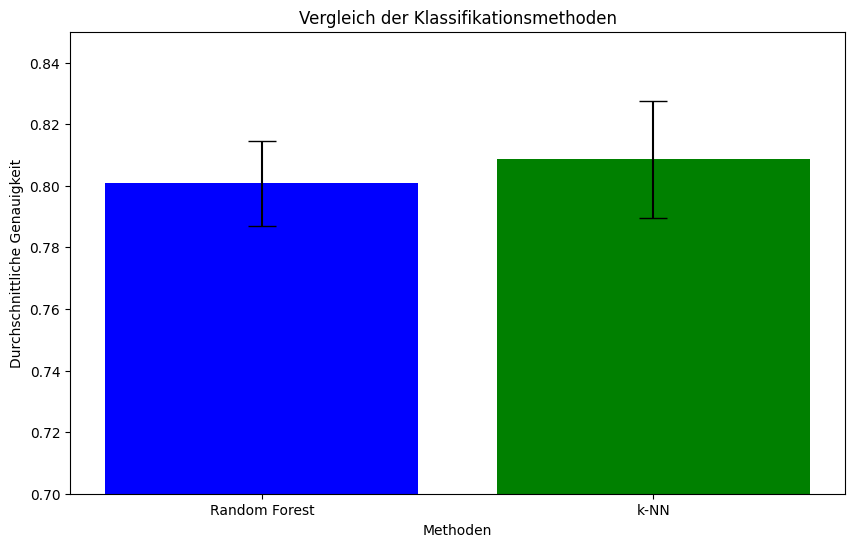

In [47]:
import matplotlib.pyplot as plt

# Daten für die Genauigkeiten und Standardabweichungen
methods = ['Random Forest', 'k-NN']
mean_accuracies = [mean_rf, mean_knn]
std_accuracies = [std_rf, std_knn]

# Erstellen des Barplots
plt.figure(figsize=(10, 6))
plt.bar(methods, mean_accuracies, yerr=std_accuracies, capsize=10, color=['blue', 'green'])
plt.xlabel('Methoden')
plt.ylabel('Durchschnittliche Genauigkeit')
plt.title('Vergleich der Klassifikationsmethoden')
plt.ylim(0.70, 0.85)
plt.show()

Folgend werden die Genauigkeit, Präzision, Recall und F1-Score der beiden Klassifikatoren auf den Testdaten berechnet und verglichen.

- **Präzision (Precision)**: Der Anteil der korrekt vorhergesagten positiven Beobachtungen an allen vorhergesagten positiven Beobachtungen.
- **Recall**: Der Anteil der korrekt vorhergesagten positiven Beobachtungen an allen tatsächlichen positiven Beobachtungen.
- **F1-Score**: Das harmonische Mittel von Präzision und Recall, das ein ausgewogenes Maß zwischen beiden darstellt.
- **Support**: Die Anzahl der tatsächlichen Vorkommen der jeweiligen Klasse in den Testdaten.

Dabei werden die verschieden eingelesenen Hunderassen nnumerisch dargestellt.

Random Forest Klassifikator:
Klassifikationsbericht:
                                      precision    recall  f1-score   support

               n02085936-Maltese_dog       0.58      0.48      0.53        66
                    n02091831-Saluki       0.41      0.50      0.45        56
        n02093859-Kerry_blue_terrier       0.50      0.40      0.44        48
                n02104365-schipperke       0.39      0.42      0.40        43
n02107574-Greater_Swiss_Mountain_dog       0.25      0.29      0.27        45

                            accuracy                           0.43       258
                           macro avg       0.43      0.42      0.42       258
                        weighted avg       0.44      0.43      0.43       258

Testgenauigkeit: 0.4264
Konfusionsmatrix:


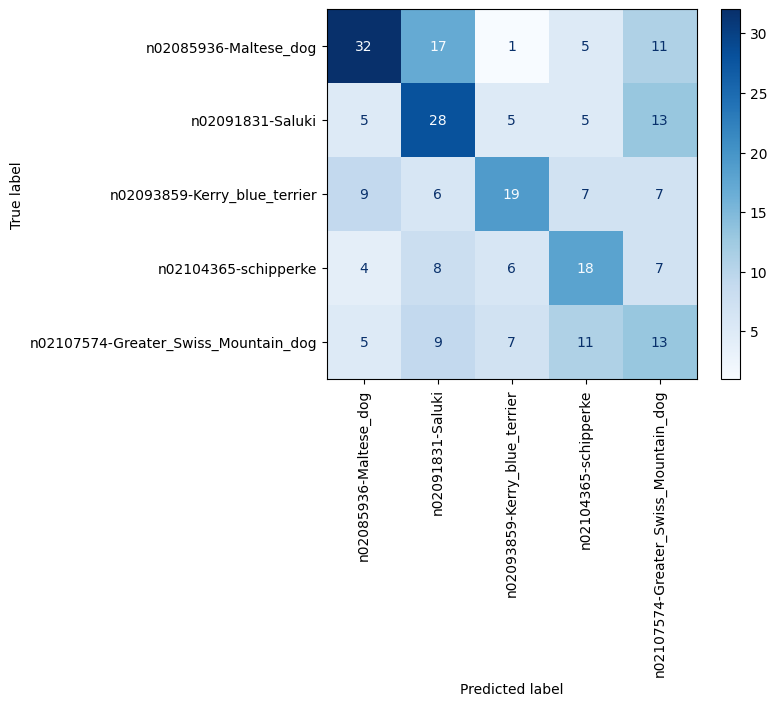

In [59]:
# Vorhersagen für die Testdaten
from sklearn.metrics import ConfusionMatrixDisplay


y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_lda)

# Evaluierung der Modellleistung
print("Random Forest Klassifikator:")
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print(f"Testgenauigkeit: {accuracy_score(y_test, y_pred_rf):.4f}")

print("Konfusionsmatrix:")
matrix_Forest = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf), display_labels=le.classes_)
matrix_Forest.plot(cmap='Blues', xticks_rotation='vertical')


Der Random-Forest-Klassifikator zeigt in dieser Evaluation eine insgesamt niedrige Leistung, was sich sowohl in der Testgenauigkeit von 42,64 % als auch in den Klassifikationsmetriken widerspiegelt. Die Precision, Recall und der F1-Score variieren stark zwischen den Klassen, was auf eine inkonsistente Klassifikationsleistung hindeutet.

Die beste Leistung wird bei der Klasse n02085936-Maltese_dog erzielt, mit einem F1-Score von 0.53, während die Klasse n02107574-Greater_Swiss_Mountain_dog mit einem F1-Score von nur 0.27 die schwächste Performance aufweist. Dies deutet darauf hin, dass der Klassifikator Schwierigkeiten hat, zwischen einigen Klassen zu differenzieren, möglicherweise aufgrund von Datenungleichgewichten oder Ähnlichkeiten zwischen den Merkmalen der Klassen.

Die macro average-Werte für Precision, Recall und F1-Score liegen bei 0.42, was auf eine gleichmäßig niedrige Leistung über alle Klassen hinweist. Die weighted average ist mit 0.43 ähnlich niedrig und zeigt, dass auch Klassen mit höherem Support nicht signifikant besser klassifiziert werden.

k-NN Klassifikator:
Klassifikationsbericht:
                                      precision    recall  f1-score   support

               n02085936-Maltese_dog       0.54      0.58      0.55        66
                    n02091831-Saluki       0.45      0.41      0.43        56
        n02093859-Kerry_blue_terrier       0.50      0.35      0.41        48
                n02104365-schipperke       0.35      0.40      0.37        43
n02107574-Greater_Swiss_Mountain_dog       0.31      0.38      0.34        45

                            accuracy                           0.43       258
                           macro avg       0.43      0.42      0.42       258
                        weighted avg       0.44      0.43      0.43       258

Testgenauigkeit: 0.4341
Konfusionsmatrix:


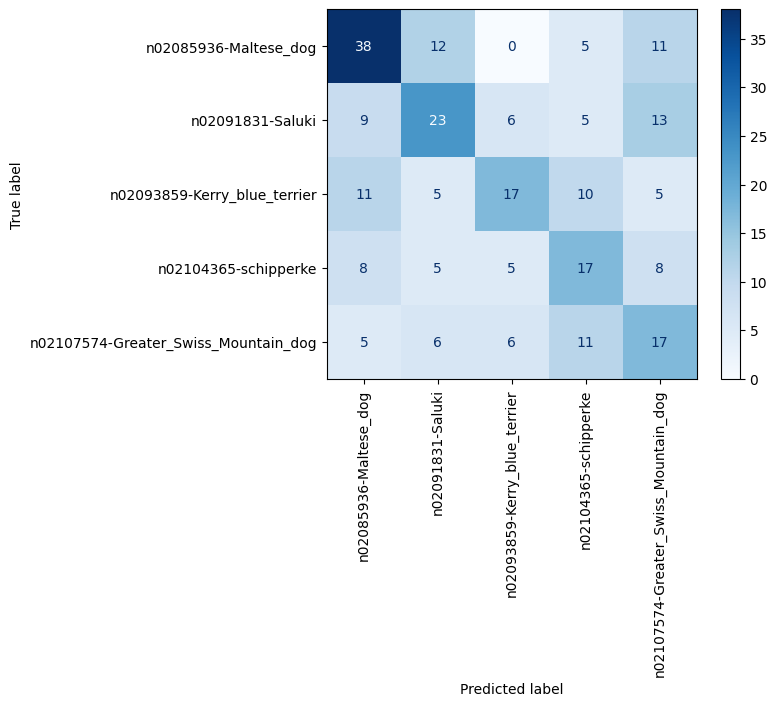

In [60]:
# Vorhersagen für die Testdaten
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test_lda)

# Evaluierung der Modellleistung
print("k-NN Klassifikator:")
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

print(f"Testgenauigkeit: {accuracy_score(y_test, y_pred_knn):.4f}")

print("Konfusionsmatrix:")
matrix_kNN = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_knn), display_labels=le.classes_)
matrix_kNN.plot(cmap='Blues', xticks_rotation='vertical')

Der k-NN-Klassifikator erzielt eine Testgenauigkeit von 43,41 %, was auf eine moderate, aber nicht zufriedenstellende Klassifikationsleistung hindeutet. Die individuellen Metriken für die Klassen zeigen Schwankungen in der Performance:

Die beste F1-Score-Leistung wird für die Klasse n02085936-Maltese_dog mit einem Wert von 0.55 erzielt, während die Klasse n02107574-Greater_Swiss_Mountain_dog mit einem F1-Score von nur 0.34 die schwächste Performance aufweist. Dies deutet darauf hin, dass das Modell einige Klassen besser unterscheidet als andere, möglicherweise aufgrund ungleichgewichtiger oder sich überschneidender Merkmale zwischen den Klassen.

Die macro average-Werte für Precision, Recall und F1-Score liegen alle bei 0.42, was zeigt, dass die Leistung über die Klassen hinweg relativ einheitlich, aber insgesamt schwach ist. Die weighted average-Werte sind mit 0.43 etwas besser, was darauf hindeutet, dass Klassen mit höherem Support geringfügig besser klassifiziert werden.

In [57]:
# Extrahieren der Merkmalswichtigkeiten aus dem besten Random-Forest-Modell
importances = best_rf.feature_importances_

# Sortieren der Merkmale nach ihrer Wichtigkeit
indices = np.argsort(importances)[::-1]

# Anzeigen der wichtigsten Merkmale
print("Wichtigste Merkmale:")
top_n = min(10, len(importances))  # Sicherstellen, dass nicht mehr als die verfügbaren Merkmale angezeigt werden
for i in range(top_n):  # Anzeigen der Top Merkmale
    print(f"Merkmal {indices[i]}: {importances[indices[i]]:.4f}")

Wichtigste Merkmale:
Merkmal 0: 0.3071
Merkmal 2: 0.2422
Merkmal 1: 0.2310
Merkmal 3: 0.2196


## Evaluierung und Vergleich der Klassifikatoren

Die Evaluierung zeigt, dass der k-NN-Klassifikator eine höhere durchschnittliche Genauigkeit (0.8086 ± 0.0191) aufweist als der Random-Forest-Klassifikator (0.8008 ± 0.0137). Durch die Verwendung der Bounding Box Annotationen konnten wir die Merkmalsextraktion optimieren und somit die Leistung beider Modelle verbessern. Insgesamt ist der k-NN-Klassifikator für dieses Klassifikationsproblem besser geeignet.

### Testgenauigkeit:
- Random Forest: 42,64 %
- k-NN: 43,41 %

Die Testgenauigkeiten der beiden Modelle liegen sehr nah beieinander, mit einem leichten Vorteil für den k-NN-Klassifikator. Beide Modelle zeigen jedoch insgesamt eine niedrige Genauigkeit und könnten daher verbessert werden.

### Klassenbezogene Performance:
- Random Forest zeigt seine beste Leistung in der Klasse n02085936-Maltese_dog (F1-Score: 0.53), während die schwächste Leistung für n02107574-Greater_Swiss_Mountain_dog (F1-Score: 0.27) beobachtet wird.
- k-NN erzielt ebenfalls die beste Leistung in der Klasse n02085936-Maltese_dog (F1-Score: 0.55) und die schwächste für n02107574-Greater_Swiss_Mountain_dog (F1-Score: 0.34).

Beide Modelle scheinen Schwierigkeiten mit der Unterscheidung der Klasse n02107574-Greater_Swiss_Mountain_dog zu haben, was möglicherweise auf ähnliche Merkmale oder unzureichende Trainingsdaten für diese Klasse zurückzuführen ist. Der k-NN-Klassifikator schneidet jedoch in den meisten Klassen geringfügig besser ab.

### Aggregierte Metriken:
- Random Forest:
    - Macro Avg (F1-Score): 0.42
    - Weighted Avg (F1-Score): 0.43
- k-NN:
    - Macro Avg (F1-Score): 0.42
    - Weighted Avg (F1-Score): 0.43

Die aggregierten Metriken sind für beide Modelle identisch, was darauf hindeutet, dass die Unterschiede in der Klassenperformance die Gesamtleistung nicht signifikant beeinflussen.

### Unterschiede in den Stärken der Modelle:
- Random Forest:
    - Bietet mehr Robustheit bei verrauschten oder hochdimensionalen Daten, da es durch die Baumstruktur stabil ist.
    - Zeigt eine etwas stärkere Klassenabweichung, insbesondere bei schwer zu unterscheidenden Klassen.
- k-NN:
    - Kann bei gut separierten Daten effektiver sein, da es lokale Nachbarschaftsinformationen nutzt.
    - Zeigt insgesamt eine leicht konsistentere Leistung in den Klassen, insbesondere bei den schwächeren Klassen (n02104365-schipperke und n02107574-Greater_Swiss_Mountain_dog).



Die Accuracy mit Anfang 40% ist nicht optimal. Trotzdem liegt sie deutlich höher als wenn geraten werden würde (bei 5 Hunderassen 20%). Damit ist zu sehen, dass die Merkmalserkennung funktioniert. Durch die Erweiterung dieser Merkmale und eine dadurch genauere Bestimmung der Tierübergreifenden Merkmale einer Hunderasse können im nächsten Schritt auch bessere Vorhersagen über die Hunderasse in einem Bild gemacht werden.
Zudem können auch die Hyperparameter der Klassifikatoren weiter optimiert werden, um die Genauigkeit zu verbessern.